In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel
from PIL import Image

d:\PyCharm_Projects\Scraping Dataset\generating-annotations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CustomStableDiffusion:
    def __init__(self, model_id="runwayml/stable-diffusion-v1-5", unet_path=None, device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Загрузка пайплайна
        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
            scheduler=DDIMScheduler.from_pretrained(model_id, subfolder="scheduler"),
            safety_checker=None  # Можно отключить, если не нужен
        ).to(self.device)

        # Заменяем UNet на кастомный (если указан путь)
        if unet_path:
            print(f"🔁 Loading custom UNet from: {unet_path}")
            unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
            state_dict = torch.load(unet_path, map_location=self.device)
            unet.load_state_dict(state_dict)
            unet.to(self.device)
            self.pipe.unet = unet

    def generate(self, prompt, height=256, width=256, num_inference_steps=50, guidance_scale=7.5):
        with torch.autocast(self.device) if self.device == "cuda" else torch.no_grad():
            image = self.pipe(
                prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale
            ).images[0]
            return image


d:\PyCharm_Projects\Scraping Dataset\generating-annotations\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\badigadii\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 6/6 [00:24<00:00,  

🔁 Loading custom UNet from: checkpoints/unet_final.pt


100%|██████████| 50/50 [15:42<00:00, 18.86s/it]


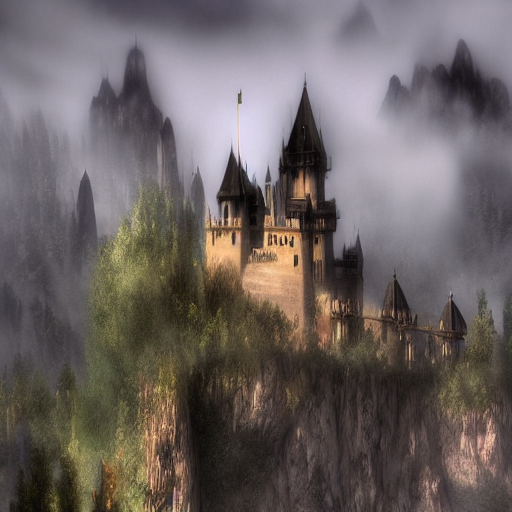

In [3]:
generator = CustomStableDiffusion(
    model_id="runwayml/stable-diffusion-v1-5",
    unet_path="checkpoints/unet_final.pt"
)

image = generator.generate("a fantasy castle surrounded by fog and mountains")
image